In [57]:
#ML PROJECT 

In [58]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('tyres_train.csv')
print(df.shape)

(3000, 16)


In [59]:
df.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0


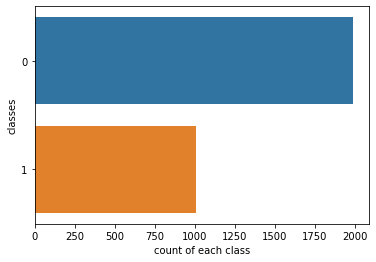

In [60]:
#Visualize Class Counts
sns.countplot(y=df.failure ,data=df) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

 - Unbalanced Dataset:
     0 labelled observations are twice the one labelled observations

in which column of our dataset is there at least a missing values?

In [8]:
df.isna().any()

vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool

In [61]:
#percentage of NaN values in "diameter"
a=df['diameter'].isna().sum();
print("NaN value in diameter:",a)
print("Perc of NaN:", a/len(df)*100,"%")


NaN value in diameter: 2110
Perc of NaN: 70.33333333333334 %


So we can omit the diameter attribute from the analysis

Attributes: 
- vulc            Numerical 
- perc_nat_rubber Numerical
- weather         Numerical
- perc_imp        Numerical
- temperature     Numerical 
- elevation       Numerical
- perc_exp_comp   Numerical
- diameter        Numerical
- tread_type      Categorical 
- tyre_season     Categorical 
- month           Categorical 
- tread_depth     Categorical 
- wiring_strenght Categorical
- tyre_quality    Categorical 
- add_layers      Categorical


Categorical attributes assume a finite number of distinct values, in most cases limited to less than a hundred, representing a qualitative property of
an entity to which they refer.
Numerical attributes assume a finite or infinite number of values and lend themselves to subtraction or division operations.

In [62]:
#come trattiamo le variabili categoriche 
print(df.dtypes)

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object


In [63]:
#non considero la colonna dei diametri perchè ci sono un sacco di nan e i valori non sono facili da predire 
cat=df[["tyre_season","month",          "tread_depth","wiring_strength","tyre_quality","tread_type","add_layers" ]]
num=df[["vulc",       "perc_nat_rubber","weather",    "perc_imp",       "temperature", "elevation", "perc_exp_comp"]]

print(cat.shape)
print(num.shape)

(3000, 7)
(3000, 7)


In [64]:
#categorical variables have the "object" type
cat = cat.astype(str)
cat.dtypes

tyre_season        object
month              object
tread_depth        object
wiring_strength    object
tyre_quality       object
tread_type         object
add_layers         object
dtype: object

In [12]:
cat.head()

,tyre_season,month,tread_depth,wiring_strength,tyre_quality,tread_type,add_layers
0,1,8,0,1,1,0,1
1,0,11,1,1,0,2,1
2,0,0,1,1,0,0,1
3,0,7,3,1,1,1,1
4,1,2,2,2,0,0,1


In [13]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


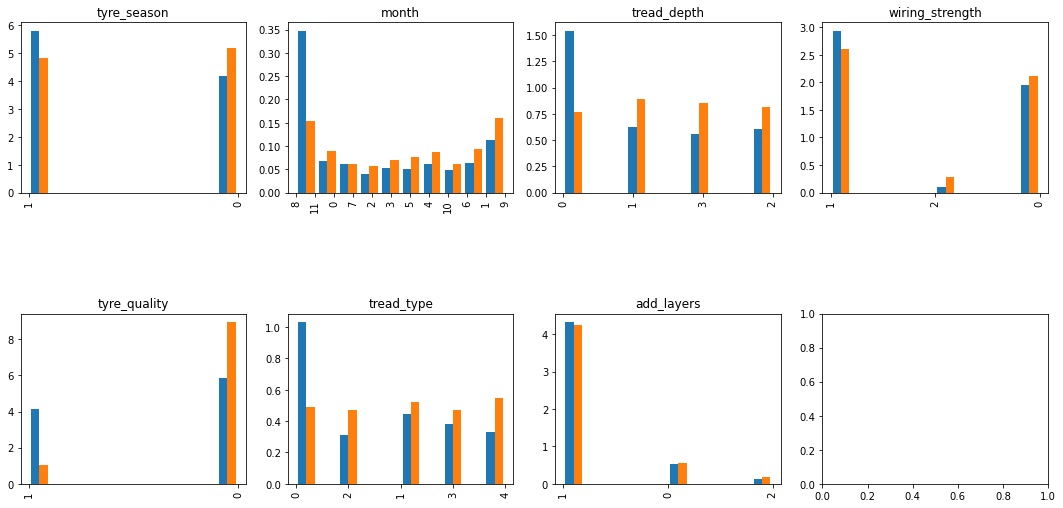

In [65]:
df_0=cat[df['failure']==0] # records wih target==0
df_1=cat[df['failure']==1] # records wih target==1


fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)
i=0

for x in cat.columns:
    plt.sca(axes[i])                         # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.xticks(rotation = 90)                # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

#blue   --> 0 test was succesfull 
#orange --> 1 test was not succesfull

# Maybe and outlier in the 8th month??????

#perchè i grafici non sono compresi tra 0 e 1 se ho messo densisty=True?

#feature selection --> different distributions are the choosen one 

We can observe a peak of 0 labeled observations in correspondence of "month" = 8. Since there are no reasons why there should be so many more 0 labeled observations in September, we will consider "month" a noise-affected attribute.

In [67]:
#try to correct month 8 
print(((df['month']==8) & (df['failure']==0)).sum())
print(((df['month']==8) & (df['failure']==1)).sum())

#too many items to delete o change the labels --> so i wont consider the month column 

655
69


In [85]:
# month NOT CONSIDERED 
new_cat=df[["tyre_season","tread_depth","wiring_strength","tyre_quality","tread_type"]]

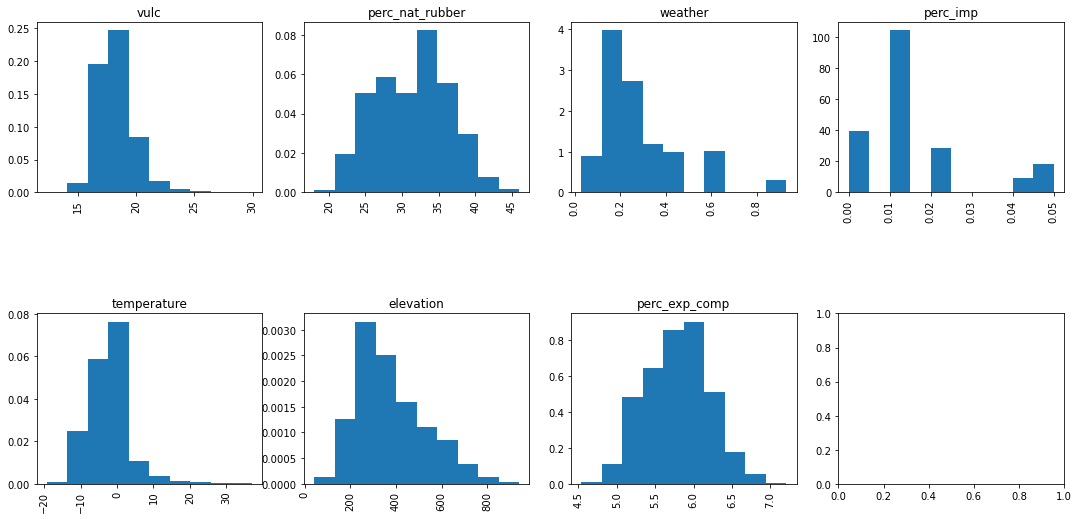

In [69]:
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in num.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist(num[x],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

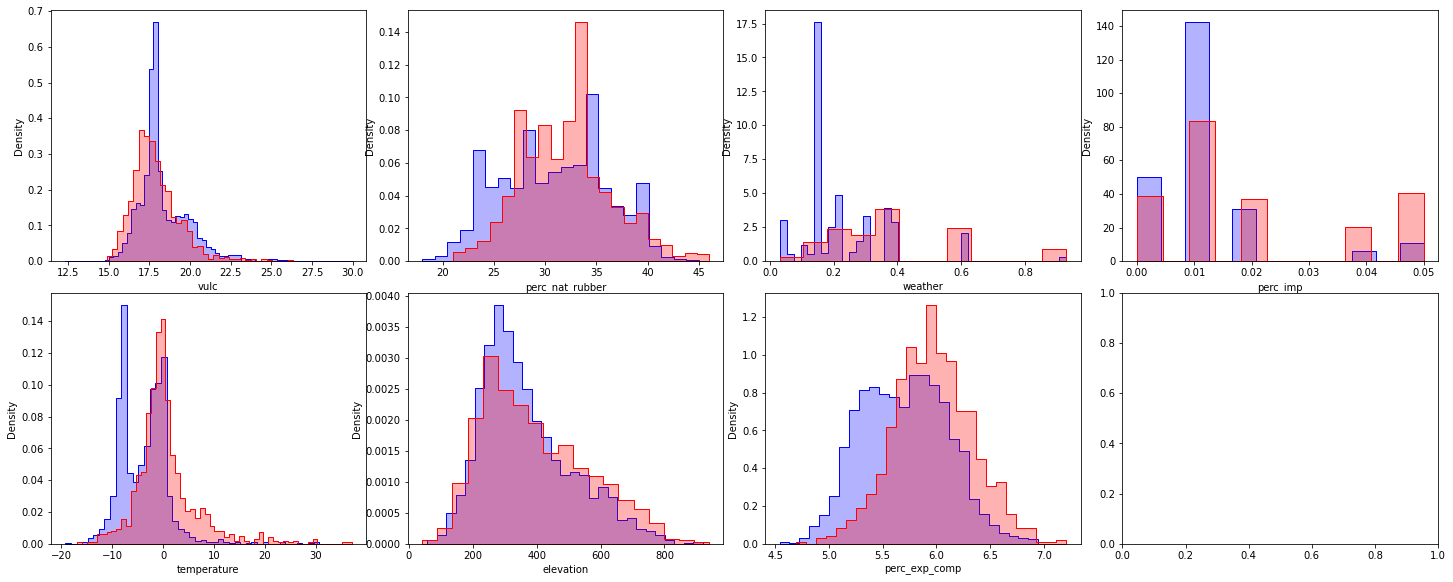

In [70]:
X0 = num[df['failure']==0]
X1 = num[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(cat.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

##provare ad applicare quache trasf

<AxesSubplot:>

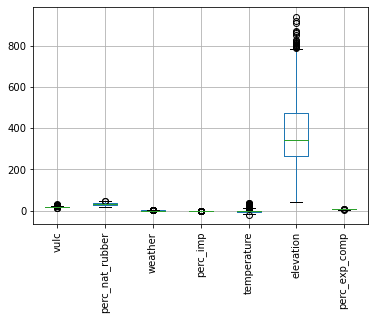

In [71]:
num.boxplot(rot=90)

#elevation has totally different numbers --> standardization 

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(num) # No target
scaled_num = pd.DataFrame(scaler.transform(num))
scaled_num.columns = num.columns
scaled_num.tail()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200


<AxesSubplot:>

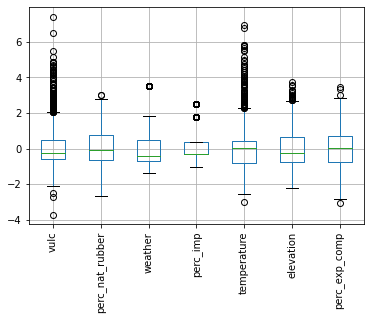

In [73]:
scaled_num.boxplot(rot=90)

#ok! 

In [19]:
#PCA fit
from sklearn.decomposition import PCA
# we can choose the number of components e.g. 10, the percentage of the total variance or set it to None (that means it automatically chooses the number of components)
pca = PCA()
pca.fit(scaled_num) #The fit learns some quantities from the data, most importantly the "components" and "explained variance"

PCA()

In [20]:
#let's use the pca to transform the dataset
num_pca = pd.DataFrame(pca.transform(scaled_num))
num_pca.columns =['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
num_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.039807,-1.005052,0.143276,0.280682,-0.055187,0.362670,0.070427
1,0.230444,1.339307,1.267905,-0.763265,0.159000,-0.653739,-0.277058
2,0.623754,0.939546,0.072528,-1.191816,0.466955,-0.734820,-0.208645
3,1.967707,1.162369,-1.581563,-0.294469,0.319924,-0.303452,0.923830
4,2.771142,0.328019,-2.985996,-0.799060,3.063998,3.395502,-0.162010
...,...,...,...,...,...,...,...
2995,0.625458,-0.250981,-0.783154,-0.636191,0.673647,1.360141,-0.495100
2996,-0.779224,-0.093864,-1.159095,-1.344233,0.107791,-0.019557,-0.391418
2997,-0.118266,-0.862350,-0.778459,-0.789547,-1.028185,0.076134,-0.574664
2998,-0.695504,1.737254,-0.289416,-0.992616,-0.390970,0.111279,0.471484


In [21]:
pd.DataFrame(pca.components_,index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'],columns=num.columns)

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
PC1,-0.080281,0.292608,0.509765,0.442437,0.469686,0.157051,0.455033
PC2,0.388180,0.472226,-0.373902,-0.496069,0.214217,0.262835,0.354203
PC3,0.796293,0.176996,0.232871,0.334312,-0.341043,0.047571,-0.223659
PC4,-0.104280,-0.256250,-0.006530,0.057527,-0.132234,0.945590,-0.092107
PC5,0.425614,-0.764839,-0.071712,0.003050,0.302535,-0.083554,0.360851
PC6,0.124018,0.013110,0.024990,-0.070775,0.705190,0.052928,-0.691896
PC7,-0.037241,0.096131,-0.735050,0.661871,0.104354,-0.008160,0.006628


In [22]:
pd.DataFrame(pca.explained_variance_).transpose()

,0,1,2,3,4,5,6
0,2.611119,1.17498,1.042926,0.946682,0.7149,0.332083,0.179644


          0         1        2         3         4         5         6
0  0.372893  0.167798  0.14894  0.135195  0.102095  0.047425  0.025655


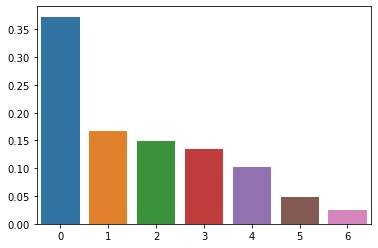

In [23]:
#VISUALIZE The percentage of variance explained by each of the selected components.
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
print(explained_var)
ax = sns.barplot( data=explained_var)

In [24]:
cum_explained_var=np.cumsum(pca.explained_variance_ratio_)
cum_explained_var= pd.DataFrame(cum_explained_var).transpose()
cum_explained_var

,0,1,2,3,4,5,6
0,0.372893,0.540691,0.689631,0.824826,0.92692,0.974345,1.0


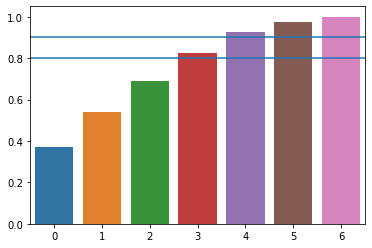

In [25]:
ax = sns.barplot(data=cum_explained_var)
ax.axhline(0.9)
ax.axhline(0.8)

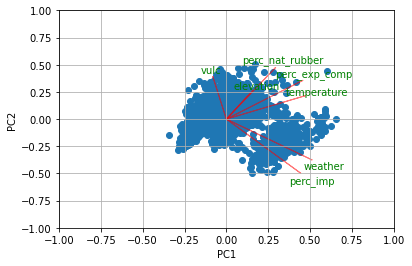

In [26]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca.transform(scaled_num)[:,0:2],np.transpose(pca.components_[0:2, :]), num.columns)
plt.show()



#perc_imp e wheater sono correlate? 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

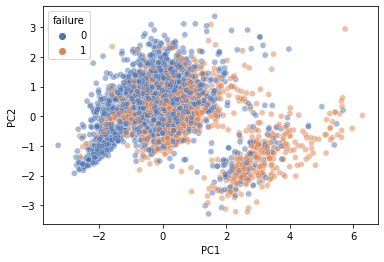

In [27]:
sns.scatterplot(x="PC1", y="PC2",
              hue=df['failure'], alpha=0.5,
              data=num_pca,
              palette='deep')

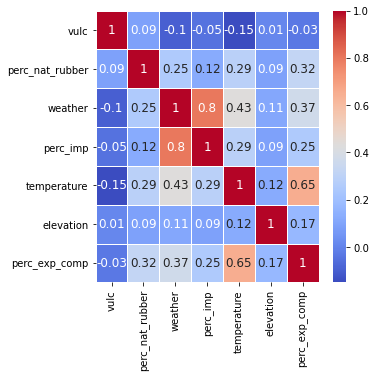

In [28]:
plt.figure(figsize = (5,5))
sns.heatmap(data=scaled_num.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

#perc_imp e  weather !! does make it sense?

## Concatenation 

In [86]:
X=pd.concat([scaled_num,new_cat], axis = 1)
print(X.shape)
X.tail()

(3000, 12)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season,tread_depth,wiring_strength,tyre_quality,tread_type
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809,1,1,2,1,1
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070,1,1,1,0,1
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937,0,3,1,1,1
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072,0,0,0,0,4
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200,0,1,2,0,1


In [87]:
y=df['failure']

In [88]:
len(y)

3000

In [89]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30,   
                                                    stratify=y,        #preserve target propotions (probviamo non stratificata)
                                                    random_state= 321) #fix random seed for replicability

print("FEATURE 0:" ,X_train.shape, X_test.shape)

FEATURE 0: (2100, 12) (900, 12)


In [90]:
#proportion preserved
print((y_train==0).sum())
print((y_train==1).sum())

1394
706


## Models

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [92]:
#funzioni 


def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))

def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

## KNN 
Whit KNN we use feature 1 beacuse the algorithm can not do features selection by it self. So we use filtered features. 

In [93]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(5,500,500)}
hyperp_search(classifier,parameters)

f1_train: 0.535073 using {'n_neighbors': 5}
f1         train 0.686   test 0.525
precision  train 0.736   test 0.570

[[487 111]
 [155 147]]


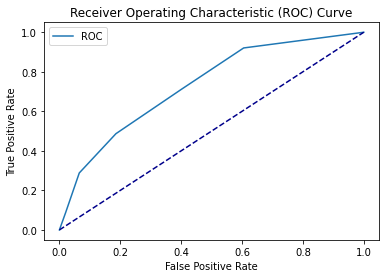

AUC: 0.73


In [94]:
model_knn = KNeighborsClassifier(n_neighbors=5)
fpr1,tpr1=roc(model_knn,X_train,y_train,X_test,y_test)

In [95]:
#Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6,8],
              'min_samples_split': [5,10,20,25],
              'min_samples_leaf': [5,10,20]}

hyperp_search(classifier,parameters)

f1_train: 0.505032 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 5}
f1         train 0.531   test 0.482
precision  train 0.743   test 0.687

[[547  51]
 [190 112]]


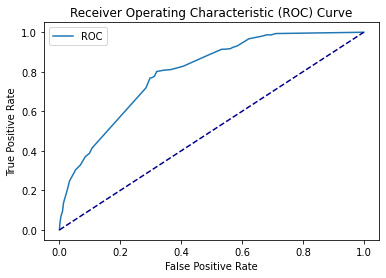

AUC: 0.80


In [97]:
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=20, min_samples_split=5)

fpr2,tpr2=roc(model_tree,X_train,y_train,X_test,y_test)


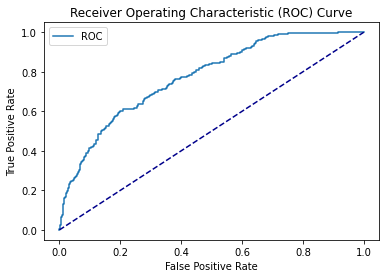

AUC: 0.77


In [98]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)



y_probs = model.predict_proba(X_test) 
fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)

In [99]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[1000] }


hyperp_search(classifier,parameters)

f1_train: 0.535858 using {'C': 1, 'max_iter': 1000}
f1         train 0.546   test 0.590
precision  train 0.654   test 0.667

[[518  80]
 [142 160]]


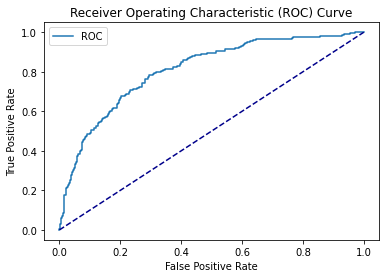

AUC: 0.81


In [52]:
model = LogisticRegression(C=1, max_iter=1000)

fpr4,tpr4=roc(model,X_train,y_train,X_test,y_test)


In [106]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','sigmoid'], "C":[0.1,50,60,70,80]}

hyperp_search(classifier,parameters)


#OVER-FITTING: using {'C': 50, 'kernel': 'rbf'}
# so we omit the 'rbf' among the possible parameters. 

f1_train: 0.527944 using {'C': 60, 'kernel': 'linear'}
f1         train 0.533   test 0.596
precision  train 0.706   test 0.725

[[540  58]
 [149 153]]


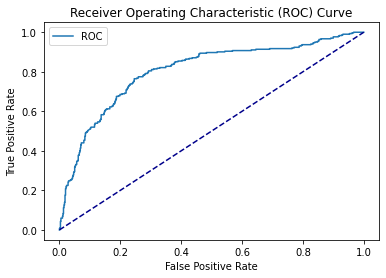

AUC: 0.80


In [107]:
model = SVC(C=60, kernel='linear',probability=True)

fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)

In [ ]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(14,7),(10, 5),(20, 10, 5),(50,10,5)],  "max_iter": [2000], "alpha": [0.001,0.1]}

hyperp_search(classifier,parameters)

#over fitting with: 'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000

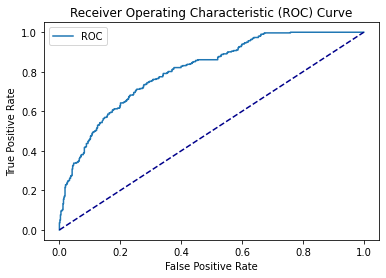

AUC: 0.81


In [111]:
model_MLP=MLPClassifier(hidden_layer_sizes=(10,5), alpha=0.1, max_iter=2000)

fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)

In [113]:
from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' : [50, 100, 200],
              'criterion' :    ['entropy', 'gini'],
              'max_depth' :    [1,2,3,4], 
              'min_samples_split': [4,5,10],
              'min_samples_leaf' : [4,5,10]
             };

hyperp_search(classifier,parameters)

f1_train: 0.512662 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
f1         train 0.545   test 0.532
precision  train 0.737   test 0.726

[[550  48]
 [175 127]]


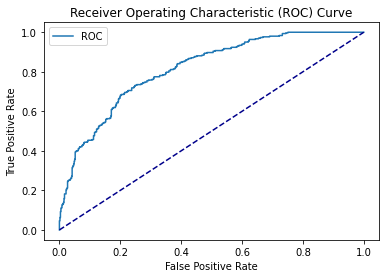

AUC: 0.81


In [118]:
rand_forest=RandomForestClassifier(criterion= 'gini', max_depth= 4, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 50)
fpr7,tpr7=roc(rand_forest,X_train,y_train,X_test,y_test)

In [115]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [2000, 5000],
              'learning_rate' : [0.0001, 0.01, 0.1, 1, 10]}

hyperp_search(classifier,parameters)

f1_train: 0.555396 using {'learning_rate': 0.01, 'n_estimators': 5000}
f1         train 0.592   test 0.560
precision  train 0.670   test 0.615

[[501  97]
 [147 155]]


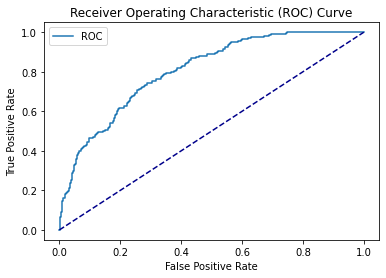

AUC: 0.81


In [119]:
AdaBoost_clf=AdaBoostClassifier(learning_rate= 0.01, n_estimators= 5000)
fpr8,tpr8=roc(AdaBoost_clf,X_train,y_train,X_test,y_test)

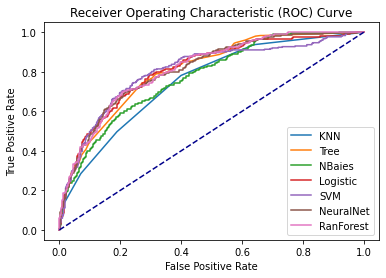

In [71]:
plt.plot(fpr1, tpr1, label= "KNN")
plt.plot(fpr2, tpr2, label= "Tree") 
plt.plot(fpr3, tpr3, label= "NBaies")   
plt.plot(fpr4, tpr4, label= "Logistic")
plt.plot(fpr5, tpr5, label= "SVM")
plt.plot(fpr6, tpr6, label= "NeuralNet")
plt.plot(fpr7, tpr7, label= "RanForest")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


| Model | AUC | F1 score |
| --- | --- | --- |
| KNN | 0.75 |  |
| Tree| 0.80|
| NBaies | 0.77 |  |
| Logistic | 0.81 |  |
| SVM | 0.80 |  |
| NeuralNet |  0.81  |  |
|RanForest | 0.81 |  |
|AdaBoost  | 0.81 |  |